In [1]:
from tensorflow.keras import layers, models

# AE 모델링
class AE(models.Model):
    # 생성자 - x_nodes 입력 노드수, z_dim 은닉 노드수
    # # 24×24(784 픽셀) 입력 이미지들이 원소 36개로 구성된 벡터로 변환된 뒤 24×24 이미지로 복구됨
    def __init__(self, x_nodes=784, z_dim=36):
        x_shape=(x_nodes,)
        x=layers.Input(shape=x_shape) # 입력 계층 
        z=layers.Dense(z_dim, activation='relu')(x) # 은닉 계층 
        y=layers.Dense(x_nodes, activation='sigmoid')(z) # 출력 계층 
        super().__init__(x,y)
        self.x=x
        self.z=z
        self.z_dim=z_dim
        self.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # 신경망 외부에서 부호화 결과를 확인하고 싶을 때 호출할 함수
    def Encoder(self):
        return models.Model(self.x, self.z)

    # 복호화를 수행하는 함수
    def Decoder(self):
        z_shape=(self.z_dim,)
        z=layers.Input(shape=z_shape)
        y_layer=self.layers[-1] # 제일 마지막 레이어가 출력 계층
        y=y_layer(z)
        return models.Model(z, y)

In [2]:
from tensorflow.keras.datasets import mnist
import numpy as np

# 데이터 로딩
# 레이블 정보는 _로 전달받음, 추후 사용되지 않는 함수의 리턴값을 받는 변수는 밑줄 _ 사용을 권장함
# AE는 비지도 학습이기에 레이블을 필요로 하지 않음, 입력 데이터를 출력 데이터에 똑같이 사용함 
(X_train, _), (X_test, _)=mnist.load_data()
# 입력값이 1 이하가 되도록 정규화
X_train=X_train.astype('float32')/255.
X_test=X_test.astype('float32')/255.
print(X_train.shape)
# 3차원에서 2차원 형태로 모양을 바꿈(차원 축소)
X_train=X_train.reshape(len(X_train), 784)
X_test=X_test.reshape(len(X_test), 784)
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(60000, 784)
(10000, 784)


In [3]:
# 파라미터 설정 (입력 노드수 784, 부호화 벡터 길이 36 - 길이가 784인 원래 이미지의 데이터 길이가 36으로 압축된)
x_nodes, z_dim=784, 36
autoencoder=AE(x_nodes,z_dim) # 모델 생성
# 모델 학습 - 입력 데이터와 출력 데이터를 동일하게 설정, fit(입력 데이터, 출력 데이터)
history=autoencoder.fit(X_train, X_train, epochs=5, batch_size=256, validation_split=0.2)

Epoch 1/5
188/188 [==============================] - 3s 12ms/step - loss: 0.4096 - accuracy: 0.0076 - val_loss: 0.1969 - val_accuracy: 0.0138
Epoch 2/5
188/188 [==============================] - 1s 4ms/step - loss: 0.1859 - accuracy: 0.0118 - val_loss: 0.1601 - val_accuracy: 0.0093
Epoch 3/5
188/188 [==============================] - 1s 4ms/step - loss: 0.1548 - accuracy: 0.0086 - val_loss: 0.1406 - val_accuracy: 0.0094
Epoch 4/5
188/188 [==============================] - 1s 4ms/step - loss: 0.1374 - accuracy: 0.0100 - val_loss: 0.1277 - val_accuracy: 0.0099
Epoch 5/5
188/188 [==============================] - 1s 4ms/step - loss: 0.1252 - accuracy: 0.0109 - val_loss: 0.1180 - val_accuracy: 0.0102


In [4]:
import matplotlib.pyplot as plt

def plot_acc(history, title=None):
    if not isinstance(history, dict):
        history=history.history
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    if title is not None:
        plt.title(title)
    plt.xlabel('에포크')
    plt.ylabel('정확도')
    plt.legend(['학습 데이터 성능', '검증 데이터 성능'], loc=0)

def plot_loss(history, title=None):
    if not isinstance(history, dict):
        history=history.history
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    if title is not None:
        plt.title(title)
    plt.xlabel('에포크')
    plt.ylabel('손실')
    plt.legend(['학습 데이터 성능', '검증 데이터 성능'], loc=0)

def plot_loss_acc(history):
    plot_loss(history,"손실 추이")
    plt.show()
    plot_acc(history,"정확도 추이")
    plt.show()

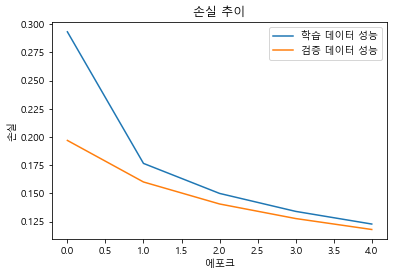

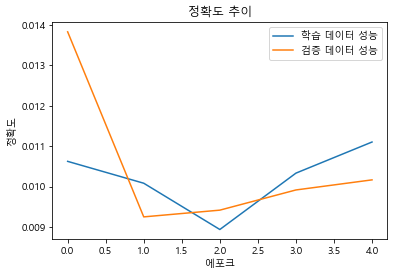

In [6]:
from matplotlib import font_manager, rc

font_location='c:/windows/fonts/malgun.ttf'
font_name=font_manager.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)

# 플로팅
plot_loss_acc(history)
# 손실 : 부호화 후, 복호화한 이미지와 원 이미지가 얼마나 유사한지를 나타냄, 손실값이 작을수록 부호화가 잘된 것
# 입력 데이터(학습에 사용되지 않은 숫자 이미지)
# 부호화 결과
# 출력 이미지

In [7]:
# AE 동작 확인
def show_ae(autoencoder):
    # 부호화, 복호화 모델의 인스턴스 생성
    encoder=autoencoder.Encoder()
    decoder=autoencoder.Decoder()
    encoded_imgs=encoder.predict(X_test) # 평가용 이미지들을 넣어서 부호화 결과와 복호화 결과 생성
    decoded_imgs=decoder.predict(encoded_imgs) # 부호화된 이미지를 넣어서 복호화 데이터를 생성함
    n=10 # 화면에 표시할 이미지의 개수
    plt.figure(figsize=(20,6)) # subplot 방식을 사용하여 10개를 하나의 그래프로 그리기 위해 그림의 전체 크기 설정
    for i in range(n):
        ax=plt.subplot(3,n,i+1)
        plt.imshow(X_test[i].reshape(28,28)) # 입력 이미지(평가용 이미지)
        plt.gray() # 흑백으로 출력
        # 이미지 주변 축들이 보이지 않게 함
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax=plt.subplot(3,n,i+1+n)
        # 이미지가 압축된 형태 (2차원 이미지를 1차원의 벡터로 압축)
        plt.stem(encoded_imgs[i].reshape(-1))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax=plt.subplot(3,n,i+1+n+n)
        # 복호화한 이미지 출력
        plt.imshow(decoded_imgs[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

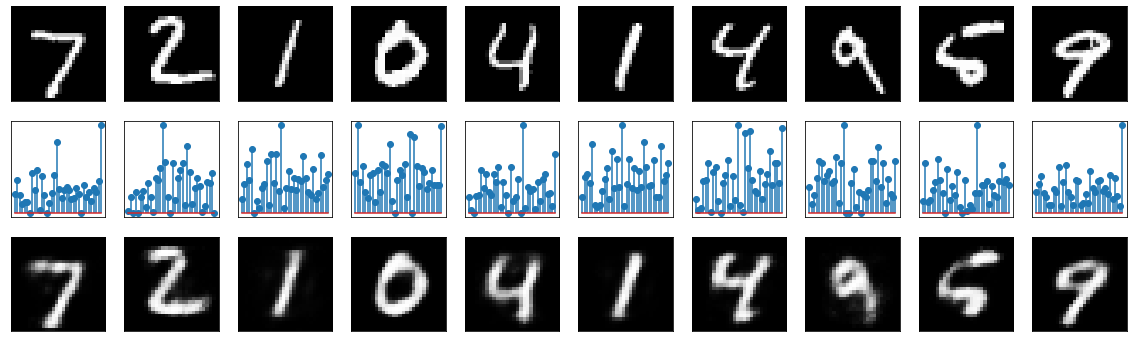

In [8]:
show_ae(autoencoder)